## Tract and Patch Geometry

For DESC-SSim call June 29 2017

Notebook demonstrating some plotting the geometry of [SkyMap](http://www.github.com/lsst/skymap). For more info, check out the utility scripts in the SkyMap [examples directory](https://github.com/lsst/skymap/tree/master/examples).

This notebook makes use of some of the LSST stack packages (i.e., `afw` and `daf`). An example kernel that loads these is available in [lsst-kernel.sh](./lsst-kernel.sh).

Validated by [@kadrlica](https://github.com/kadrlica): 2017-12-06

In [1]:
%matplotlib inline

import sys
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.daf.persistence as dafPersist

## For Seaborn users
#import seaborn as sns
#sns.set(context='talk',
#        style='whitegrid',
#        palette='deep',
#        font='sans-serif',
#        font_scale=0.8,
#        color_codes=True,
#        rc={'text.usetex': False})

DATA_DIR = '.'
DATA_DIR = '/global/cscratch1/sd/descdm/DC1'  # ON NERSC


I want to access the SkyMaps locally. First, I pulled over the SkyMaps from the repos on NERSC and made minimal repositories on my laptop:

    $ ls *
    DC1-imsim-dithered:
    _mapper		deepCoadd/skyMap.pickle

    DC1-phoSim-3a:
    _mapper		deepCoadd/skyMap.pickle

    full_focalplane_undithered:
    _mapper		deepCoadd/skyMap.pickle
    
    $ cat full_focalplane_undithered/_mapper 
        lsst.obs.lsstSim.LsstSimMapper

In [2]:
# To access the skymap construct a butler with the repo and ask for the "deepCoadd_skyMap"
butler = dafPersist.Butler(os.path.join(DATA_DIR, 'full_focalplane_undithered'))
skyMap = butler.get("deepCoadd_skyMap")

In [3]:
def makePatch(vertexList, wcs):
    """Return a path in sky coords from vertex list in pixel coords"""
    
    skyPatchList = [wcs.pixelToSky(pos).getPosition(afwGeom.degrees) for pos in vertexList]
    verts = [(coord[0], coord[1]) for coord in skyPatchList]
    verts.append((0,0))
    codes = [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY,
             ]
    return Path(verts, codes)   

In [4]:
 def plotSkyMap(skyMap, tract=0, title="Patch Geometry"):
    tractInfo = skyMap[tract]
    tractBox = afwGeom.Box2D(tractInfo.getBBox())
    tractPosList = tractBox.getCorners()
    wcs = tractInfo.getWcs()
    xNum, yNum = tractInfo.getNumPatches()

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    for x in range(xNum):
        for y in range(yNum):
            patchInfo = tractInfo.getPatchInfo([x, y])
            patchBox = afwGeom.Box2D(patchInfo.getOuterBBox())
            pixelPatchList = patchBox.getCorners()
            path = makePatch(pixelPatchList, wcs)
            patch = patches.PathPatch(path, alpha=0.1, lw=1)
            ax.add_patch(patch)
            center = wcs.pixelToSky(patchBox.getCenter()).getPosition(afwGeom.degrees)
            ax.text(center[0], center[1], '%d,%d'%(x,y), size=6, ha="center", va="center")

    skyPosList = [wcs.pixelToSky(pos).getPosition(afwGeom.degrees) for pos in tractPosList]
    ax.set_xlim(max(coord[0] for coord in skyPosList) + 1,
                min(coord[0] for coord in skyPosList) - 1)
    ax.set_ylim(min(coord[1] for coord in skyPosList) - 1, 
                max(coord[1] for coord in skyPosList) + 1)
    ax.grid(ls=':',color='gray')
    ax.set_xlabel("RA (deg.)")
    ax.set_ylabel("Dec (deg.)")
    ax.set_title(title)
    return ax


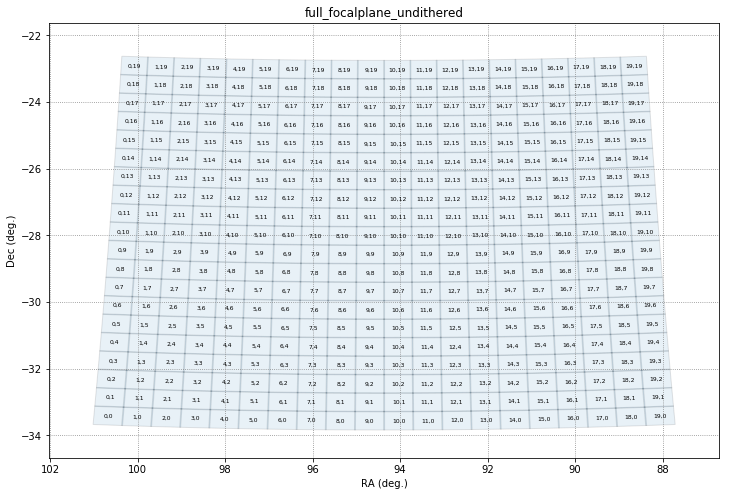

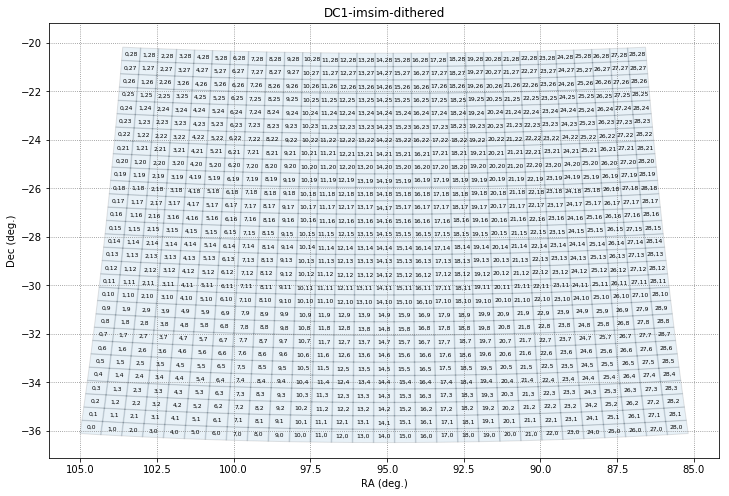

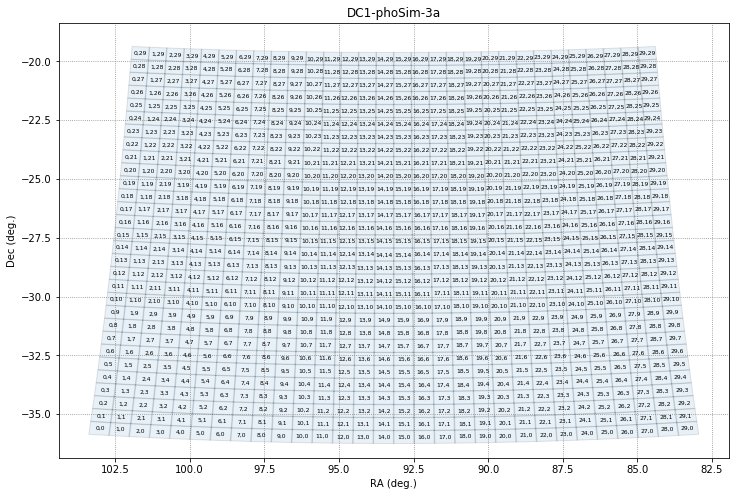

In [5]:
for directory in ['full_focalplane_undithered',
                 'DC1-imsim-dithered',
                 'DC1-phoSim-3a']:
    butler = dafPersist.Butler(os.path.join(DATA_DIR, directory))
    skyMap = butler.get("deepCoadd_skyMap")
    plotSkyMap(skyMap, tract=0, title=directory)


## Zoom in
to see the difference between innerBBox and outerBBox

Text(0.5,1,'Zoom in')

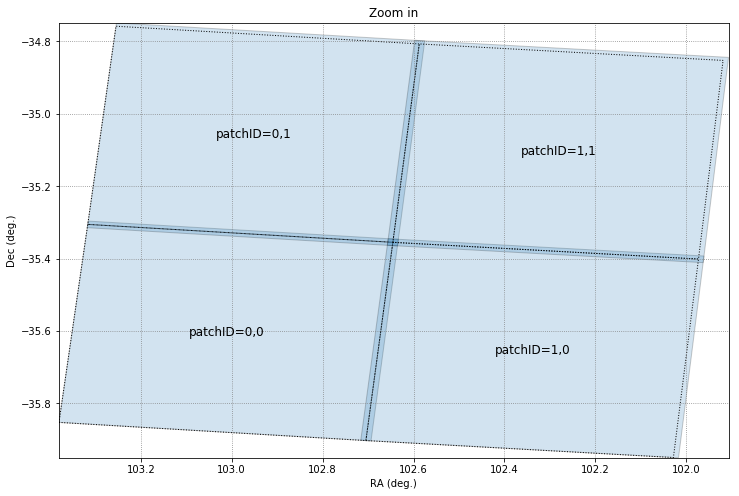

In [6]:
tractInfo = skyMap[0]
wcs = tractInfo.getWcs()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plotBox = afwGeom.Box2D(tractInfo.getPatchInfo([0, 0]).getOuterBBox())
for x in range(2):
    for y in range(2):
        # Plot outer BBOX
        patchInfo = tractInfo.getPatchInfo([x, y])
        patchBox = afwGeom.Box2D(patchInfo.getOuterBBox())
        plotBox.include(patchBox)
        pixelPatchList = patchBox.getCorners()
        path = makePatch(pixelPatchList, wcs)
        patch = patches.PathPatch(path, alpha=0.2, lw=1)
        ax.add_patch(patch)
        # Plot inner BBox
        patchBox = afwGeom.Box2D(patchInfo.getInnerBBox())
        pixelPatchList = patchBox.getCorners()
        path = makePatch(pixelPatchList, wcs)
        patch = patches.PathPatch(path, fill=None, lw=1, 
                                  linestyle='dotted', color='k')
        ax.add_patch(patch)
               
        center = wcs.pixelToSky(patchBox.getCenter()).getPosition(afwGeom.degrees)
        ax.text(center[0], center[1], 'patchID=%d,%d'%(x,y), size=12, ha="center", va="center")

skyPosList = [wcs.pixelToSky(pos).getPosition(afwGeom.degrees) for pos in plotBox.getCorners()]
ax.set_xlim(max(coord[0] for coord in skyPosList),
            min(coord[0] for coord in skyPosList))
ax.set_ylim(min(coord[1] for coord in skyPosList), 
            max(coord[1] for coord in skyPosList))
ax.grid(ls=":", color="gray")
ax.set_xlabel("RA (deg.)")
ax.set_ylabel("Dec (deg.)")
ax.set_title("Zoom in")

## Overlay visit

Use [`showVisitSkyMap.py`](https://github.com/lsst/skymap/blob/u/yusra/lsstSim/examples/showVisitSkyMap.py) with some tweaks to work with `lsstSim`. Run like:

    
    $> python $SKYMAP_DIR/examples/showVisitSkyMap.py /global/cscratch1/sd/descdm/DC1/full_focalplane_undithered 0 237447 --showPatch --saveFile "undithered_237447.png"
    $> python $SKYMAP_DIR/examples/showVisitSkyMap.py /global/cscratch1/sd/descdm/DC1/full_focalplane_undithered 0 237447^237449 --showCcds --showPatch --saveFile "undithered_237447_237449.png"